Binary classification between subjects with ICD10 cat 10 and those whithout!

### \\\ Currently used ///

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
# use multiple GPUs
gpu = 6
multi_gpus = None#[0, 1, 2]
b = 4
zero_one_normalize = False
dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
table = "/analysis/ritter/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [9]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
0,0,1100042,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100042,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,0YY,1NN,1NN,1NN,9Na,9Na
1,1,1100675,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100675,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,9else,1NN,0YY,9else,1NN,9else,9Na,9Na
2,2,1180478,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1180478,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,2YN,0YY,1NN,0YY,9Na,9Na
3,3,1112124,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1112124,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,9else,0YY,0YY,0YY,9else,1NN,1NN,9Na,9Na
4,4,1148079,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1148079,20252_2_0,20253_2_0,20249_2_0,Female,[],...,3SitY,3NY,0YY,3NY,0YY,3NY,1NN,1NN,9Na,9Na


In [10]:
# shuffle the dataset
df = df.sample(frac=0.2, random_state=23)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
791,791,1109592,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1109592,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,3NY,1NN,0YY,1NN,1NN,3NY,MH.VH,VH.VH
1705,1705,1197086,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1197086,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,0YY,0YY,9else,2YN,3NY,0YY,1NN,9Na,9Na
167,167,1092621,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1092621,20252_2_0,20253_2_0,20249_2_0,Female,[],...,"4SitR,5DocR",2YN,1NN,1NN,1NN,1NN,3NY,1NN,9Na,9Na
331,331,1037619,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1037619,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,2YN,0YY,3NY,3NY,1NN,1NN,0YY,9Na,9Na
651,651,1161652,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1161652,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,3NY,3NY,1NN,0YY,1NN,3NY,2YN,9Na,9Na


In [11]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        #label = self.df.iloc[idx]['ICD10_G_bool']
        #label = torch.FloatTensor([int(label)])
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [12]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [13]:
intensity = IntensityRescale(masked=False)
input_trans = transforms.Compose(augmentations + [intensity, ToTensor()])
#input_trans = transforms.Compose([ToTensor()])

In [14]:
ukb_data = UKBGDataset(df, transform=input_trans, mask=mask)#, z_factor=0.5)

In [15]:
len(ukb_data)

371

In [16]:
# split train/test
train_df = df.sample(frac=0.8, random_state=32)
test_df = df[~df["PTID"].isin(train_df["PTID"])]

In [17]:
sample = ukb_data[3]
img = sample["image"]

In [18]:
img.shape

torch.Size([1, 182, 218, 182])

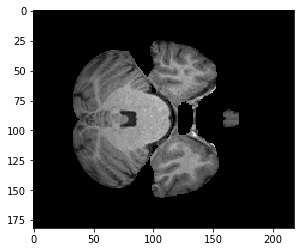

In [19]:
plt.imshow(img[0][:,:,40], cmap='gray')

In [20]:
sample["label"]

tensor([1.])

# Define the classifier

In [21]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=0)
        self.bn_1 = nn.BatchNorm3d(16)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0)
        self.bn_2 = nn.BatchNorm3d(32)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.bn_3 = nn.BatchNorm3d(64)
        self.Conv_4 = nn.Conv3d(64, 32, kernel_size=3, stride=1, padding=0)
        self.bn_4 = nn.BatchNorm3d(32)
        self.Conv_5 = nn.Conv3d(32, 16, kernel_size=3, stride=1, padding=0)
        self.bn_5 = nn.BatchNorm3d(16)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=3, padding=0)
        
        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            #nn.Dropout(0.6),
            nn.Linear(7056, 512),
            #nn.Dropout(0.6),
            nn.Linear(512, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.relu(self.bn_1(self.Conv_1(x)))
        h = self.dropout(self.pool_1(x))
        x = F.relu(self.bn_2(self.Conv_2(h)))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.relu(self.bn_3(self.Conv_3(h)))
        if print_size:
            print(x.shape)
        x = F.relu(self.bn_4(self.Conv_4(x)))
        if print_size:
            print(x.shape)
        x = F.relu(self.bn_5(self.Conv_5(x)))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_4(x))
        if print_size:
            print(h.shape)
        
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [22]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [23]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 3752849


# Training

In [24]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    #for train_idx, val_idx in kf.split(data):#, df["label"]):
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
        #optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=True)
        
        #sched = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=12)
        #sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=5)

         # split train/validation
        train_df = data.sample(frac=0.8, random_state=32)
        val_df = data[~data["PTID"].isin(train_df["PTID"])]

        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
        train_loader = DataLoader(
            ukb_data_train, batch_size=b, shuffle=True, num_workers=4
        )

        val_loader = DataLoader(
            ukb_data_val, batch_size=2, shuffle=True, num_workers=2
        )

        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            #scheduler=sched,
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=20,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models


In [25]:
num_epochs = 200
min_iters = 3
ignore_epochs = 15
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [26]:
r = 0

In [27]:
#output_dir = "/analysis/fabiane/models/MS/pretrained/from_keras/pytorch_finetuned/hdf5"
# ModelCheckpoint(path=output_dir,
                             #prepend="repeat_{}".format(r),
                             #store_best=True,
                             #ignore_before=ignore_epochs,
                             #retain_metric=retain_metric),
callbacks = [EarlyStopping(patience=8, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]

Starting trial 0
[0,    20] loss: 1.03574
[0,    40] loss: 0.88419
Time elapsed: 0h:0m:36s
train accuracy_score: 60.50 %
train balanced_accuracy: 59.89 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.44 %
Val loss: 0.883606
[1,    20] loss: 0.99511
[1,    40] loss: 0.88232
Time elapsed: 0h:1m:25s
train accuracy_score: 49.58 %
train balanced_accuracy: 48.31 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 1.312341
[2,    20] loss: 0.75227
[2,    40] loss: 1.04428
Time elapsed: 0h:2m:14s
train accuracy_score: 52.94 %
train balanced_accuracy: 51.73 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.44 %
Val loss: 0.819035
[3,    20] loss: 0.81765
[3,    40] loss: 0.79779
Time elapsed: 0h:3m:3s
train accuracy_score: 55.46 %
train balanced_accuracy: 54.07 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 1.013581
[4,    20] loss: 0.77379
[4,    40] loss: 0.86459
Time elapsed: 0h:3m:54s
train accuracy_score: 57.14 %
train balanced_accur

[38,    20] loss: 0.49061
[38,    40] loss: 0.50671
Time elapsed: 0h:31m:43s
train accuracy_score: 76.47 %
train balanced_accuracy: 75.12 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.78 %
Val loss: 0.505284
[39,    20] loss: 0.41736
[39,    40] loss: 0.35993
Time elapsed: 0h:32m:31s
train accuracy_score: 78.99 %
train balanced_accuracy: 79.18 %
val accuracy_score: 62.71 %
val balanced_accuracy: 64.52 %
Val loss: 0.601608
[40,    20] loss: 0.62051
[40,    40] loss: 0.51583
Time elapsed: 0h:33m:20s
train accuracy_score: 73.11 %
train balanced_accuracy: 71.35 %
val accuracy_score: 64.41 %
val balanced_accuracy: 66.13 %
Val loss: 0.575986
[41,    20] loss: 0.38233
[41,    40] loss: 0.39554
Time elapsed: 0h:34m:10s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.11 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.44 %
Val loss: 0.431386
[42,    20] loss: 0.36477
[42,    40] loss: 0.47617
Time elapsed: 0h:34m:59s
train accuracy_score: 78.57 %
train balanced_accura

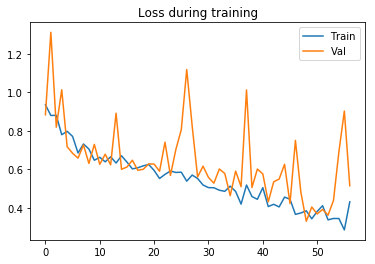

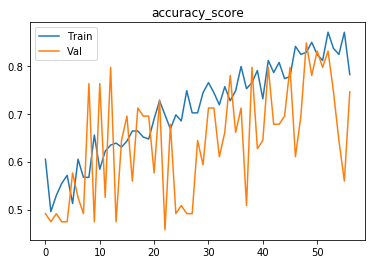

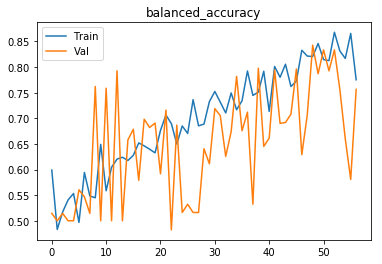

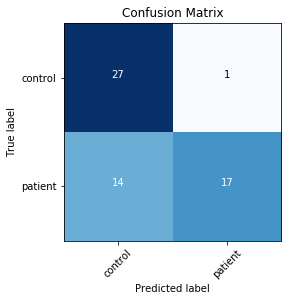

Starting trial 1
[0,    20] loss: 1.66052
[0,    40] loss: 1.12428
Time elapsed: 0h:0m:37s
train accuracy_score: 49.16 %
train balanced_accuracy: 47.25 %
val accuracy_score: 47.46 %
val balanced_accuracy: 45.51 %
Val loss: 0.702712
[1,    20] loss: 0.87353
[1,    40] loss: 0.74649
Time elapsed: 0h:1m:27s
train accuracy_score: 50.00 %
train balanced_accuracy: 48.91 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.727601
[2,    20] loss: 1.14484
[2,    40] loss: 0.78358
Time elapsed: 0h:2m:17s
train accuracy_score: 59.24 %
train balanced_accuracy: 58.32 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.780895
[3,    20] loss: 0.83288
[3,    40] loss: 0.93145
Time elapsed: 0h:3m:6s
train accuracy_score: 47.06 %
train balanced_accuracy: 45.97 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.944534
[4,    20] loss: 0.77350
[4,    40] loss: 0.55283
Time elapsed: 0h:3m:55s
train accuracy_score: 58.82 %
train balanced_accur

[38,    20] loss: 0.47823
[38,    40] loss: 0.45756
Time elapsed: 0h:32m:53s
train accuracy_score: 79.83 %
train balanced_accuracy: 79.12 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.91 %
Val loss: 0.479024
[39,    20] loss: 0.51261
[39,    40] loss: 0.41591
Time elapsed: 0h:33m:42s
train accuracy_score: 78.15 %
train balanced_accuracy: 77.52 %
val accuracy_score: 62.71 %
val balanced_accuracy: 64.34 %
Val loss: 0.584864
[40,    20] loss: 0.40075
[40,    40] loss: 0.48119
Time elapsed: 0h:34m:35s
train accuracy_score: 78.57 %
train balanced_accuracy: 78.00 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.86 %
Val loss: 0.467767
[41,    20] loss: 0.30734
[41,    40] loss: 0.46018
Time elapsed: 0h:35m:24s
train accuracy_score: 80.25 %
train balanced_accuracy: 78.80 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.01 %
Val loss: 0.413925
[42,    20] loss: 0.53292
[42,    40] loss: 0.50793
Time elapsed: 0h:36m:15s
train accuracy_score: 76.05 %
train balanced_accura

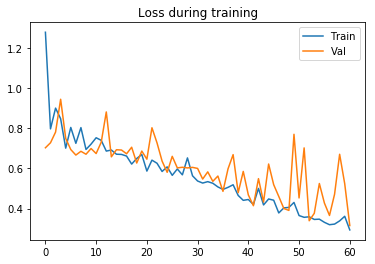

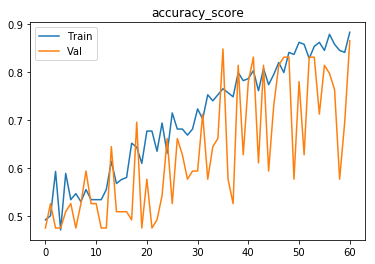

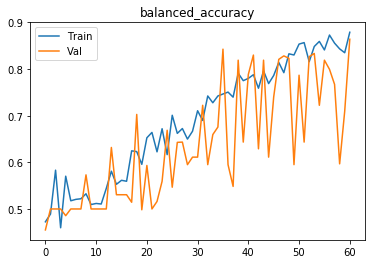

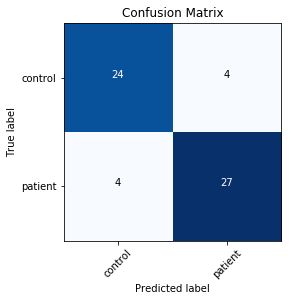

Starting trial 2
[0,    20] loss: 1.93177
[0,    40] loss: 1.04005
Time elapsed: 0h:0m:37s
train accuracy_score: 47.06 %
train balanced_accuracy: 45.39 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.684546
[1,    20] loss: 0.80193
[1,    40] loss: 0.84158
Time elapsed: 0h:1m:25s
train accuracy_score: 51.68 %
train balanced_accuracy: 49.81 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.718206
[2,    20] loss: 0.77339
[2,    40] loss: 1.08734
Time elapsed: 0h:2m:15s
train accuracy_score: 50.42 %
train balanced_accuracy: 49.51 %
val accuracy_score: 71.19 %
val balanced_accuracy: 71.20 %
Val loss: 0.667636
[3,    20] loss: 0.88331
[3,    40] loss: 0.74527
Time elapsed: 0h:3m:3s
train accuracy_score: 50.00 %
train balanced_accuracy: 48.68 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.44 %
Val loss: 0.724185
[4,    20] loss: 0.89449
[4,    40] loss: 0.72053
Time elapsed: 0h:4m:4s
train accuracy_score: 55.46 %
train balanced_accura

[38,    20] loss: 0.61289
[38,    40] loss: 0.56783
Time elapsed: 0h:36m:44s
train accuracy_score: 79.83 %
train balanced_accuracy: 78.77 %
val accuracy_score: 69.49 %
val balanced_accuracy: 70.45 %
Val loss: 0.516739
[39,    20] loss: 0.49472
[39,    40] loss: 0.50881
Time elapsed: 0h:37m:34s
train accuracy_score: 73.95 %
train balanced_accuracy: 73.24 %
val accuracy_score: 59.32 %
val balanced_accuracy: 60.94 %
Val loss: 0.534637
[40,    20] loss: 0.36199
[40,    40] loss: 0.50059
Time elapsed: 0h:38m:38s
train accuracy_score: 78.57 %
train balanced_accuracy: 77.77 %
val accuracy_score: 59.32 %
val balanced_accuracy: 60.94 %
Val loss: 0.555565
[41,    20] loss: 0.33652
[41,    40] loss: 0.35004
Time elapsed: 0h:39m:26s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.06 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.49 %
Val loss: 0.446028
Early stopping in epoch 42
Total time elapsed: 0h:39m:42s
Finished fold.


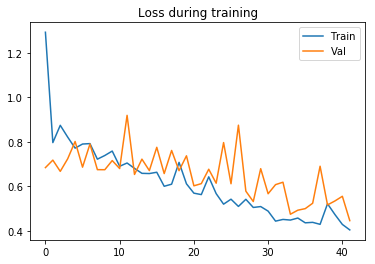

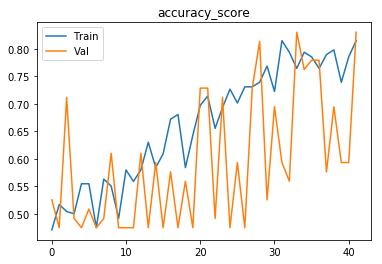

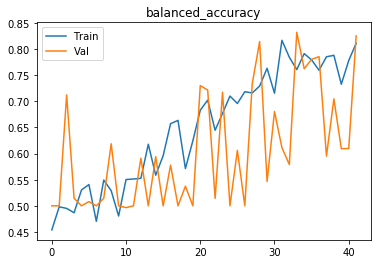

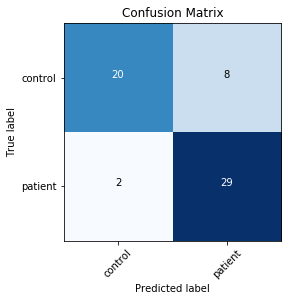

Starting trial 3
[0,    20] loss: 1.43150
[0,    40] loss: 0.90570
Time elapsed: 0h:0m:37s
train accuracy_score: 53.36 %
train balanced_accuracy: 51.18 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.44 %
Val loss: 0.691628
[1,    20] loss: 0.75534
[1,    40] loss: 0.76042
Time elapsed: 0h:1m:44s
train accuracy_score: 55.88 %
train balanced_accuracy: 53.98 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.44 %
Val loss: 0.702244
[2,    20] loss: 0.87881
[2,    40] loss: 0.73919
Time elapsed: 0h:2m:33s
train accuracy_score: 56.72 %
train balanced_accuracy: 54.03 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.742021
[3,    20] loss: 0.70058
[3,    40] loss: 0.77855
Time elapsed: 0h:3m:25s
train accuracy_score: 57.56 %
train balanced_accuracy: 56.61 %
val accuracy_score: 57.63 %
val balanced_accuracy: 57.60 %
Val loss: 0.678456
[4,    20] loss: 0.77357
[4,    40] loss: 0.72355
Time elapsed: 0h:4m:30s
train accuracy_score: 52.94 %
train balanced_accu

[38,    20] loss: 0.56676
[38,    40] loss: 0.60451
Time elapsed: 0h:36m:18s
train accuracy_score: 70.59 %
train balanced_accuracy: 68.67 %
val accuracy_score: 50.85 %
val balanced_accuracy: 53.05 %
Val loss: 0.883651
Early stopping in epoch 39
Total time elapsed: 0h:36m:29s
Finished fold.


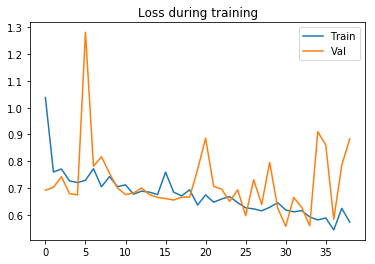

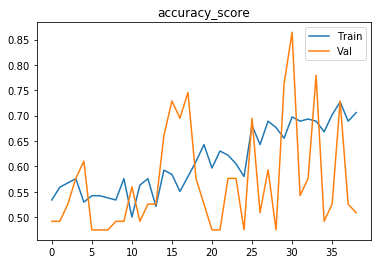

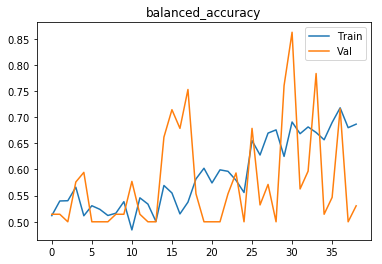

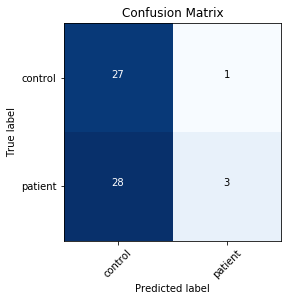

Starting trial 4
[0,    20] loss: 1.90781
[0,    40] loss: 1.33658
Time elapsed: 0h:0m:38s
train accuracy_score: 50.84 %
train balanced_accuracy: 49.76 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 1.288933
[1,    20] loss: 0.97227
[1,    40] loss: 0.86711
Time elapsed: 0h:1m:28s
train accuracy_score: 47.90 %
train balanced_accuracy: 46.02 %
val accuracy_score: 59.32 %
val balanced_accuracy: 58.53 %
Val loss: 0.682605
[2,    20] loss: 0.90081
[2,    40] loss: 1.03562
Time elapsed: 0h:2m:24s
train accuracy_score: 46.64 %
train balanced_accuracy: 44.79 %
val accuracy_score: 55.93 %
val balanced_accuracy: 56.68 %
Val loss: 0.685375
[3,    20] loss: 0.73959
[3,    40] loss: 0.78334
Time elapsed: 0h:3m:14s
train accuracy_score: 53.78 %
train balanced_accuracy: 52.59 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.835729
[4,    20] loss: 0.71515
[4,    40] loss: 0.73034
Time elapsed: 0h:4m:9s
train accuracy_score: 57.98 %
train balanced_accur

[38,    20] loss: 0.55055
[38,    40] loss: 0.46556
Time elapsed: 0h:36m:54s
train accuracy_score: 73.95 %
train balanced_accuracy: 72.66 %
val accuracy_score: 52.54 %
val balanced_accuracy: 54.67 %
Val loss: 0.610233
[39,    20] loss: 0.60639
[39,    40] loss: 0.58962
Time elapsed: 0h:37m:56s
train accuracy_score: 70.59 %
train balanced_accuracy: 69.47 %
val accuracy_score: 50.85 %
val balanced_accuracy: 53.23 %
Val loss: 0.800708
[40,    20] loss: 0.48520
[40,    40] loss: 0.46535
Time elapsed: 0h:38m:49s
train accuracy_score: 79.41 %
train balanced_accuracy: 78.51 %
val accuracy_score: 64.41 %
val balanced_accuracy: 64.40 %
Val loss: 0.607447
[41,    20] loss: 0.48797
[41,    40] loss: 0.44863
Time elapsed: 0h:39m:40s
train accuracy_score: 76.47 %
train balanced_accuracy: 75.81 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.975601
Early stopping in epoch 42
Total time elapsed: 0h:39m:51s
Finished fold.


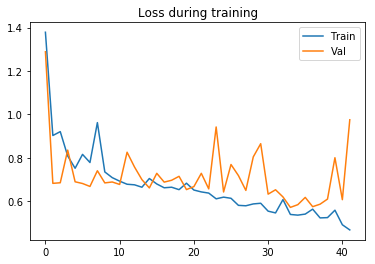

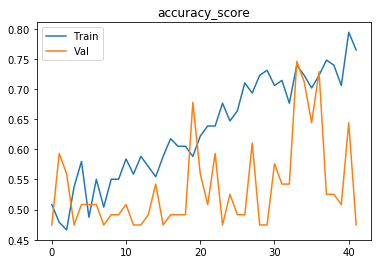

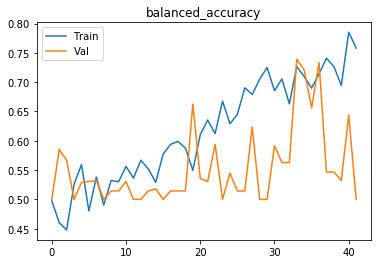

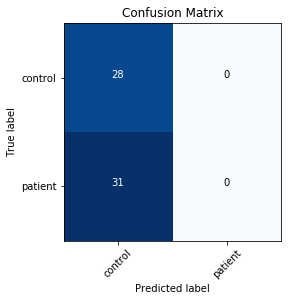

Starting trial 5
[0,    20] loss: 1.76413
[0,    40] loss: 1.27563
Time elapsed: 0h:0m:39s
train accuracy_score: 47.90 %
train balanced_accuracy: 46.82 %
val accuracy_score: 50.85 %
val balanced_accuracy: 52.36 %
Val loss: 0.696507
[1,    20] loss: 1.15283
[1,    40] loss: 0.82708
Time elapsed: 0h:1m:44s
train accuracy_score: 49.58 %
train balanced_accuracy: 48.54 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.61 %
Val loss: 0.705332
[2,    20] loss: 0.76094
[2,    40] loss: 0.85723
Time elapsed: 0h:2m:39s
train accuracy_score: 46.64 %
train balanced_accuracy: 44.56 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.44 %
Val loss: 0.761364
[3,    20] loss: 0.77311
[3,    40] loss: 0.74237
Time elapsed: 0h:3m:39s
train accuracy_score: 51.68 %
train balanced_accuracy: 49.81 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.998818
[4,    20] loss: 0.84841
[4,    40] loss: 0.76723
Time elapsed: 0h:4m:33s
train accuracy_score: 51.26 %
train balanced_accu

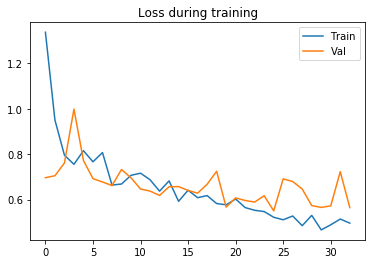

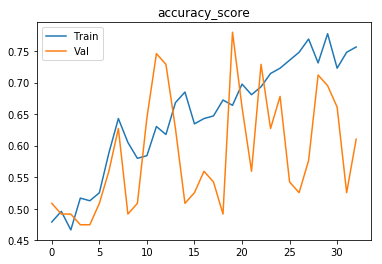

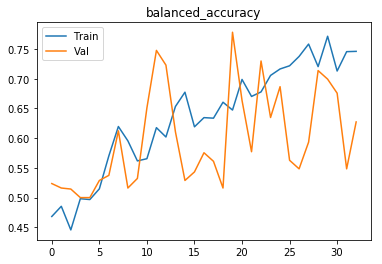

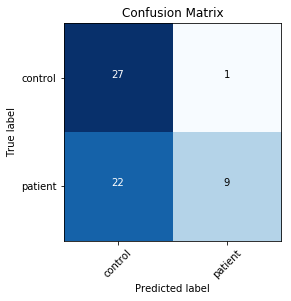

Starting trial 6
[0,    20] loss: 1.50779
[0,    40] loss: 1.02901
Time elapsed: 0h:0m:37s
train accuracy_score: 47.48 %
train balanced_accuracy: 46.45 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.810908
[1,    20] loss: 0.81743
[1,    40] loss: 0.91445
Time elapsed: 0h:1m:37s
train accuracy_score: 50.42 %
train balanced_accuracy: 48.82 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.730783
[2,    20] loss: 0.80628
[2,    40] loss: 0.82070
Time elapsed: 0h:2m:32s
train accuracy_score: 50.00 %
train balanced_accuracy: 48.45 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.784754
[3,    20] loss: 0.82508
[3,    40] loss: 0.68812
Time elapsed: 0h:3m:21s
train accuracy_score: 53.78 %
train balanced_accuracy: 52.13 %
val accuracy_score: 59.32 %
val balanced_accuracy: 60.43 %
Val loss: 0.656389
[4,    20] loss: 0.65170
[4,    40] loss: 0.70608
Time elapsed: 0h:4m:17s
train accuracy_score: 64.71 %
train balanced_accu

[38,    20] loss: 0.33760
[38,    40] loss: 0.32861
Time elapsed: 0h:34m:33s
train accuracy_score: 82.35 %
train balanced_accuracy: 81.80 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.78 %
Val loss: 0.404239
[39,    20] loss: 0.36823
[39,    40] loss: 0.29619
Time elapsed: 0h:35m:22s
train accuracy_score: 87.39 %
train balanced_accuracy: 86.93 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.70 %
Val loss: 0.397402
[40,    20] loss: 0.28006
[40,    40] loss: 0.28584
Time elapsed: 0h:36m:14s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.45 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.18 %
Val loss: 0.342363
[41,    20] loss: 0.22189
[41,    40] loss: 0.39680
Time elapsed: 0h:37m:2s
train accuracy_score: 86.55 %
train balanced_accuracy: 85.85 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.29 %
Val loss: 0.351625
[42,    20] loss: 0.38856
[42,    40] loss: 0.58374
Time elapsed: 0h:37m:50s
train accuracy_score: 78.15 %
train balanced_accurac

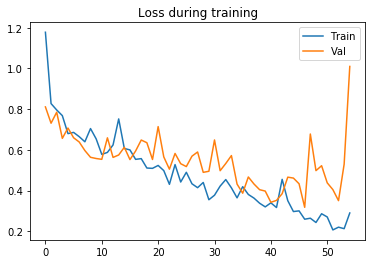

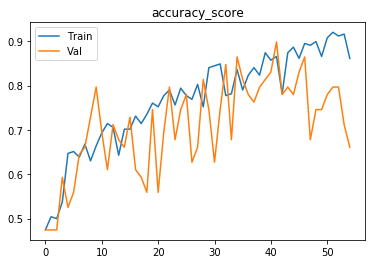

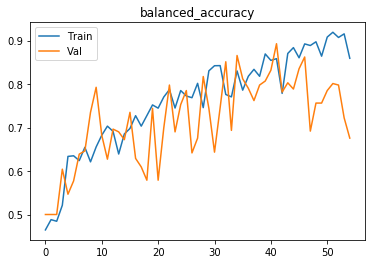

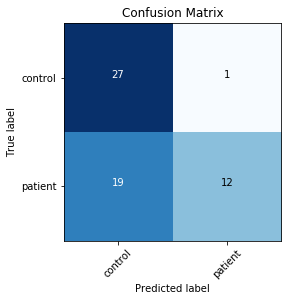

Starting trial 7
[0,    20] loss: 1.82740
[0,    40] loss: 0.90180
Time elapsed: 0h:0m:39s
train accuracy_score: 51.68 %
train balanced_accuracy: 50.04 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.714050
[1,    20] loss: 0.87427
[1,    40] loss: 1.05546
Time elapsed: 0h:1m:50s
train accuracy_score: 54.20 %
train balanced_accuracy: 53.99 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 1.713452
[2,    20] loss: 1.07150
[2,    40] loss: 0.98390
Time elapsed: 0h:3m:0s
train accuracy_score: 55.04 %
train balanced_accuracy: 54.62 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.739682
[3,    20] loss: 0.81700
[3,    40] loss: 0.82802
Time elapsed: 0h:3m:49s
train accuracy_score: 51.26 %
train balanced_accuracy: 50.02 %
val accuracy_score: 66.10 %
val balanced_accuracy: 66.19 %
Val loss: 0.676515
[4,    20] loss: 0.73682
[4,    40] loss: 0.80284
Time elapsed: 0h:4m:44s
train accuracy_score: 52.10 %
train balanced_accur

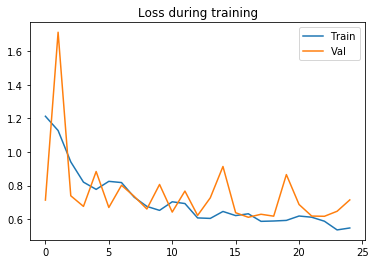

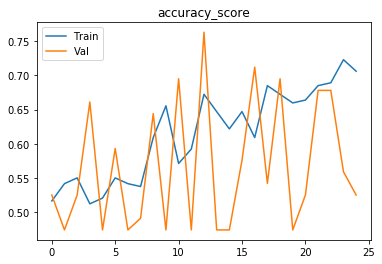

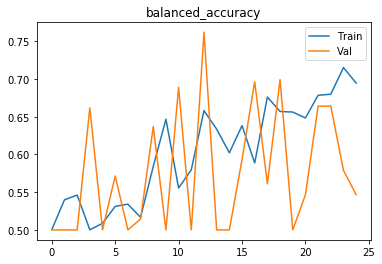

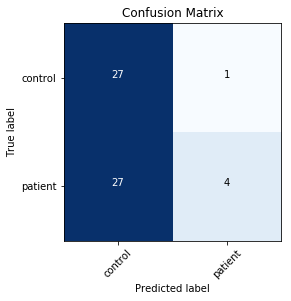

Starting trial 8
[0,    20] loss: 1.17003
[0,    40] loss: 1.19621
Time elapsed: 0h:0m:36s
train accuracy_score: 60.50 %
train balanced_accuracy: 59.55 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 1.130530
[1,    20] loss: 1.04222
[1,    40] loss: 0.91014
Time elapsed: 0h:1m:25s
train accuracy_score: 52.10 %
train balanced_accuracy: 50.07 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.44 %
Val loss: 0.811100
[2,    20] loss: 0.74220
[2,    40] loss: 0.64844
Time elapsed: 0h:2m:21s
train accuracy_score: 56.30 %
train balanced_accuracy: 54.69 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.44 %
Val loss: 0.828802
[3,    20] loss: 0.84182
[3,    40] loss: 0.78440
Time elapsed: 0h:3m:11s
train accuracy_score: 53.36 %
train balanced_accuracy: 52.56 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 1.253896
[4,    20] loss: 0.82457
[4,    40] loss: 1.01125
Time elapsed: 0h:4m:6s
train accuracy_score: 54.62 %
train balanced_accur

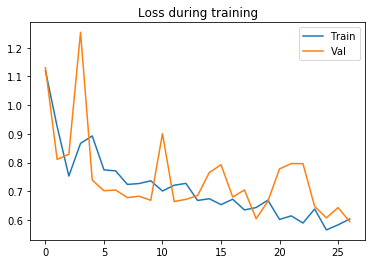

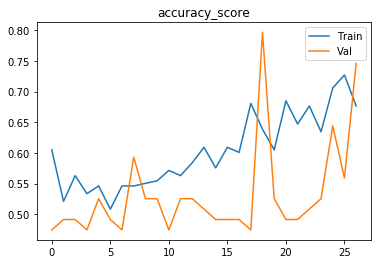

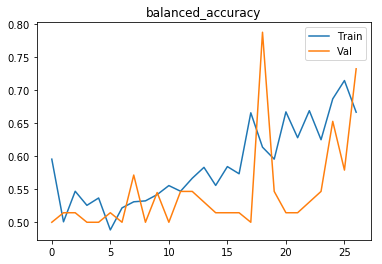

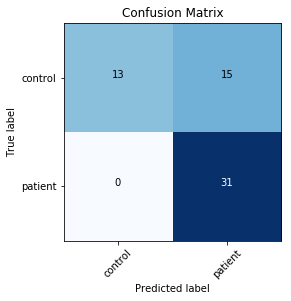

Starting trial 9
[0,    20] loss: 2.42794
[0,    40] loss: 1.14119
Time elapsed: 0h:0m:36s
train accuracy_score: 54.20 %
train balanced_accuracy: 53.30 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.44 %
Val loss: 0.762667
[1,    20] loss: 0.79165
[1,    40] loss: 0.82669
Time elapsed: 0h:1m:24s
train accuracy_score: 46.64 %
train balanced_accuracy: 44.68 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.727557
[2,    20] loss: 0.82167
[2,    40] loss: 0.71390
Time elapsed: 0h:2m:12s
train accuracy_score: 52.52 %
train balanced_accuracy: 51.47 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 1.353846
[3,    20] loss: 0.82119
[3,    40] loss: 0.69694
Time elapsed: 0h:3m:0s
train accuracy_score: 55.88 %
train balanced_accuracy: 54.55 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.44 %
Val loss: 0.742279
[4,    20] loss: 0.74257
[4,    40] loss: 0.67264
Time elapsed: 0h:4m:9s
train accuracy_score: 57.14 %
train balanced_accura

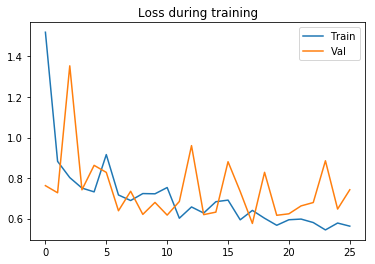

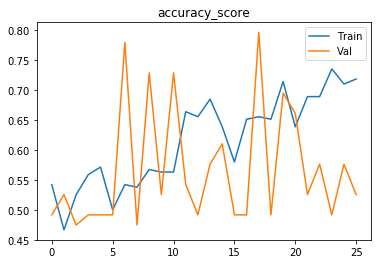

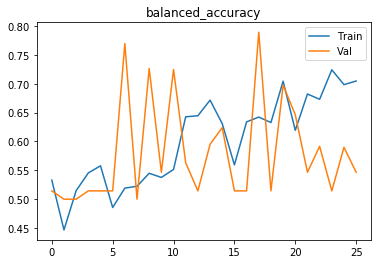

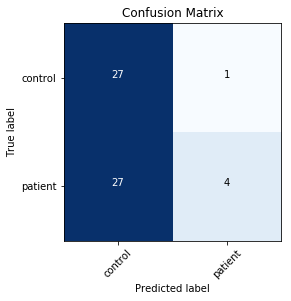

################################
################################
All accuracies: [0.756336405529954, 0.8640552995391705, 0.8248847926267282, 0.5305299539170507, 0.5, 0.6273041474654378, 0.6756912442396313, 0.5466589861751152, 0.7321428571428572, 0.5466589861751152]
0.6604262672811061
0.12356339891730596


In [28]:
fold_metric, models = run(net=net, data=train_df,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [29]:
5/0

ZeroDivisionError: division by zero

In [ ]:
output_dir = "/analysis/ritter/projects/Methods/Eitel_local_filter/models"

In [ ]:
def save_model(model, full_path):
    print("Writing model to disk...")
    model = model.cpu()
    torch.save(model.state_dict(), full_path)

In [ ]:
save_models = False

In [ ]:
if save_models:
    for i, model in enumerate(models):
        model_dir = os.path.join(output_dir, "adni_baseline_499k_augmentation_copy1_84_acc_trial_{}.h5".format(i))
        save_model(model, model_dir)

# Start inference

In [30]:
if zero_one_normalize:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
else:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
            
test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [31]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    #print(all_preds)
    #print(all_labels)
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))


Fold 0
0.6857142857142857
Fold 1
0.863003663003663
Fold 2
0.8787545787545787
Fold 3
0.5
Fold 4
0.5
Fold 5
0.6714285714285715
Fold 6
0.6142857142857143
Fold 7
0.5142857142857142
Fold 8
0.6765567765567766
Fold 9
0.5428571428571428
######## Final results ########
          0
0  0.685714
1  0.863004
2  0.878755
3  0.500000
4  0.500000
5  0.671429
6  0.614286
7  0.514286
8  0.676557
9  0.542857
Balanced accuracy mean 64.47 %
